here i will implement all the code for ex3

In [51]:
import cv2
import numpy as np
from numpy.typing import NDArray
from typing import *
from matplotlib import pyplot as plt
from scipy.signal import convolve2d

In [332]:

def pyrmdDown(image : NDArray[Any]) -> NDArray[Any]:
    gaussian_kernel  = np.array([[1/16,1/8,1/16],[1/8,1/4,1/8],[1/16,1/8,1/16]])   
    if min(image.shape[:2]) <4 :
        return image
    if image.ndim == 3:
        new_image = np.zeros((image.shape[0],image.shape[1],image.shape[2]))
        new_image[:,:,0] = convolve2d(image[:,:,0],gaussian_kernel,mode='same',boundary='symm')
        new_image[:,:,1] = convolve2d(image[:,:,1],gaussian_kernel,mode='same',boundary='symm')
        new_image[:,:,2] = convolve2d(image[:,:,2],gaussian_kernel,mode='same',boundary='symm')
        return new_image[::2,::2,:]
    if image.ndim == 2:
        new_image = np.zeros((image.shape[0],image.shape[1]))
        new_image = convolve2d(image[:,:],gaussian_kernel,mode='same',boundary='symm')
        return new_image[::2,::2]
    return image

def warp_colors(image : NDArray[Any])->NDArray[Any]:
    return np.round((image - np.min(image))/(np.max(image)-np.min(image))*255).astype('int')

def histogram_equivlent(image):
    pass

def pyrmdUp(image : NDArray[Any]) -> NDArray[Any]:
    xkernel,ykernel = np.array([[1/2,1,1/2]]),np.array([[1/2],[1],[1/2]])
    if image.ndim == 3:
        new_image = np.zeros((image.shape[0]*2,image.shape[1]*2,image.shape[2]))
        new_image[::2,::2,:]= image
        new_image[:,:,0] = convolve2d(convolve2d(new_image[:,:,0],xkernel,mode='same'),ykernel,mode='same')
        new_image[:,:,1] = convolve2d(convolve2d(new_image[:,:,1],xkernel,mode='same'),ykernel,mode='same')
        new_image[:,:,2] = convolve2d(convolve2d(new_image[:,:,2],xkernel,mode='same'),ykernel,mode='same')
        return np.round(new_image)
    if image.ndim == 2:
        new_image = np.zeros((image.shape[0]*2,image.shape[1]*2))
        new_image[::2,::2]=image
        return np.round(convolve2d(convolve2d(new_image,xkernel,mode='same'),ykernel,mode='same'))
    return image

def show_images(matrices):
    num_matrices = len(matrices)

    if num_matrices == 1:
        if matrices[0].ndim == 3:
            plt.imshow((matrices[0]))
        else:
            plt.imshow(-matrices[0],cmap='Grays')
        plt.axis('off')
    else:
        num_cols = 3
        num_rows = int(np.ceil(num_matrices / num_cols))
        fig, axes = plt.subplots(num_rows, num_cols)
        for i, matrix in enumerate(matrices):
            row = i // num_cols
            col = i % num_cols
            print(num_matrices,num_cols)
            if num_matrices <= num_cols:
                if matrix.ndim == 3:
                    axes[i].imshow((matrix))
                else:
                    axes[i].imshow(-matrix,cmap='Grays')
                axes[i].axis('off')
            else:
                if matrix.ndim == 3:
                    axes[row, col].imshow((matrix))
                else:
                    axes[row, col].imshow(-matrix,cmap='Grays')
                axes[row, col].axis('off')
        for i in range(num_matrices, num_rows * num_cols):
            if num_matrices == 2:
                axes[i].axis('off')
            else:
                axes.flatten()[i].axis('off')

    plt.tight_layout()
    plt.show()

def gaussian_pyramid(image, levels=None):
    if levels is None:
        levels = int(np.log2(np.min(image.shape[:2]))//1)-1
    pyramid = [image]
    for _ in range(levels):
        image = pyrmdDown(image)
        pyramid.append(image)

    return pyramid

def laplacian_pyramid(image):
    gaussian = gaussian_pyramid(image)
    laplacian = [gaussian[-1]]
    for i in range(len(gaussian)-1, 0, -1):
        expanded = pyrmdUp(gaussian[i])
        rows, cols = gaussian[i - 1].shape[:2]
        laplacian.append(gaussian[i - 1] - expanded[:rows, :cols])
    return laplacian

def resize(image : NDArray[Any], size : Tuple[int,int]) -> NDArray[Any]:
        return cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)

def blend_images(image1, image2, mask):
    if image1.shape[:2] != image2.shape[:2] or image1.shape[:2] != mask.shape[:2]:
        raise ValueError(f'Images and mask must have the same size\n got {mask.shape} , {image1.shape} , {image2.shape}')

    if image1.ndim == 3:
        mask = np.stack([mask,mask,mask],axis=2)
    image1_pyramid = laplacian_pyramid(image1)
    image2_pyramid = laplacian_pyramid(image2)
    mask_pyramid = gaussian_pyramid(mask)
    blended = image1_pyramid[0] * mask_pyramid[-1] + image2_pyramid[0] * (1 - mask_pyramid[-1])
    for i in range(1,len(image1_pyramid)):
        rows,cols = mask_pyramid[-i-1].shape[:2]
        blended = pyrmdUp(blended)[:rows,:cols]+image1_pyramid[i] * mask_pyramid[-i-1] + image2_pyramid[i] * (1 - mask_pyramid[-i-1])

    blended[np.where(blended<0)] = 0
    blended[np.where(blended>255)] = 255
    return blended.astype('int')

def hybrid_images(image1, image2,weight = 0.75):
    if image2.shape[:2] != image1.shape[:2]:
        raise ValueError(f'Images and mask must have the same size\n got {image1.shape} , {image2.shape}')

    image1_pyramid = laplacian_pyramid(image1)
    image2_pyramid = laplacian_pyramid(image2)
    sizes = gaussian_pyramid(image2)

    blended = image1_pyramid[0]
    for i in range(1,int(weight*len(image1_pyramid))):
        rows,cols = sizes[-i-1].shape[:2]
        blended = pyrmdUp(blended)[:rows,:cols]+image1_pyramid[i]
    
    for i in range(int(weight*len(image1_pyramid)),len(image1_pyramid)):
        rows,cols = sizes[-i-1].shape[:2]
        blended = pyrmdUp(blended)[:rows,:cols]+image2_pyramid[i]

    blended[np.where(blended<0)] = 0
    blended[np.where(blended>255)] = 255
    return blended.astype('int')




2 3
2 3


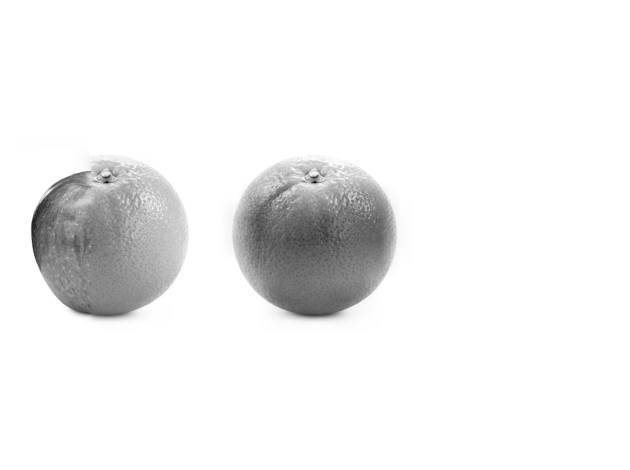

9 3
9 3
9 3
9 3
9 3
9 3
9 3
9 3
9 3


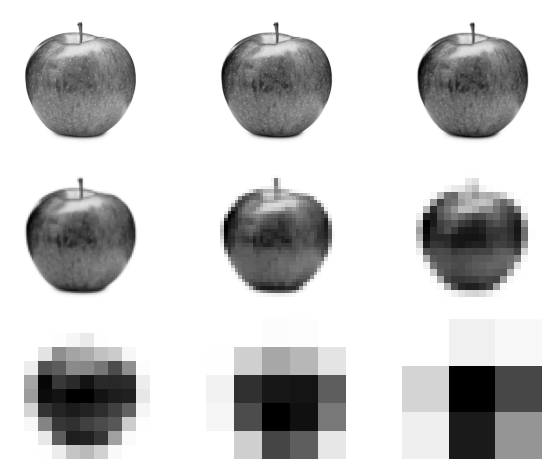

9
9 3
9 3
9 3
9 3
9 3
9 3
9 3
9 3
9 3


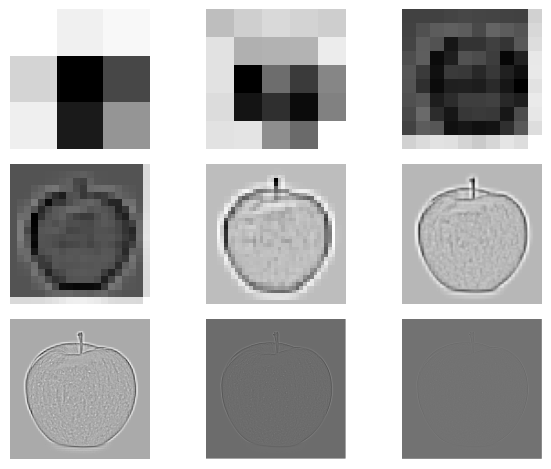

In [333]:
image1 = cv2.cvtColor(cv2.imread('./apple.jpeg'),cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(cv2.imread('./orange.jpeg'),cv2.COLOR_BGR2GRAY)

max_size = (max(image1.shape[0],image2.shape[0]),max(image1.shape[1],image2.shape[1]))
gray_image1 = resize(image1,max_size)
gray_image2 = resize(image2,max_size)

mask = np.zeros(max_size)
mask[:,:256]=1
show_images([blend_images(gray_image1,gray_image2,mask),hybrid_images(gray_image1,gray_image2,0.4)])
show_images(gaussian_pyramid(gray_image1))
print(len(laplacian_pyramid(gray_image1)))
show_images(laplacian_pyramid(gray_image1))

3 3
3 3
3 3


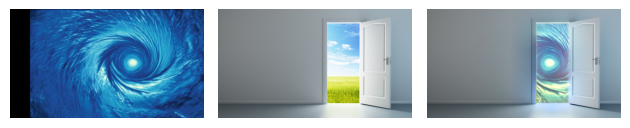

In [334]:
image1 = cv2.cvtColor(cv2.imread('./vortex.png'),cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread('./door.png'),cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('./vortexmask.png'),cv2.COLOR_BGR2GRAY)
mask[mask>100]=1
max_size = (max(image1.shape[1],image2.shape[1]),max(image1.shape[0],image2.shape[0]))
gray_image1 = resize(image1,max_size)
gray_image2 = resize(image2,max_size)
mask = resize(mask,max_size)
mask = 1- mask
show_images([gray_image1,gray_image2,blend_images(gray_image1,gray_image2,mask)])

3 3
3 3
3 3


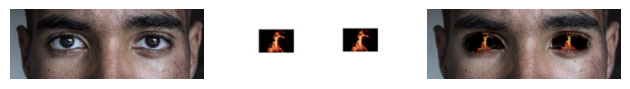

In [342]:
image1 = cv2.cvtColor(cv2.imread('./image1A.jpeg'),cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(cv2.imread('./image1B.jpeg'),cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('./mask1.jpeg'),cv2.COLOR_BGR2GRAY)
mask[mask<255]=0,
mask[mask>=255]=1
max_size = (max(image1.shape[1],image2.shape[1])*4,max(image1.shape[0],image2.shape[0])*4)
gray_image1 = resize(image1,max_size)
gray_image2 = resize(image2,max_size)
mask = resize(mask,max_size)
show_images([gray_image1,gray_image2,blend_images(gray_image1,gray_image2,mask)])

2 3
2 3


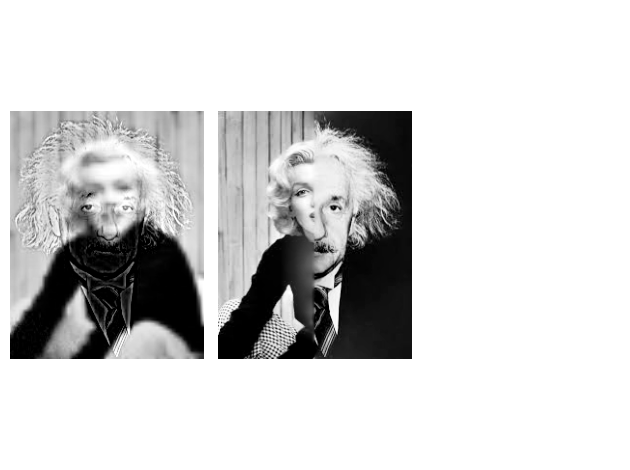

In [343]:
image1 = cv2.imread('./marlin.jpeg')
image2 = cv2.imread('./einstain.jpeg')

max_size = (max(image1.shape[0],image2.shape[0]),max(image1.shape[1],image2.shape[1]))

gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray_image1 = cv2.resize(gray_image1,max_size[::-1])
gray_image2 = cv2.resize(gray_image2,max_size[::-1])
# show_images([image1,gray_image1])
mask = np.zeros(max_size)
mask[:,:max_size[1]//2]=1
blended = blend_images(gray_image1,gray_image2,mask)
show_images([hybrid_images(gray_image1,gray_image2),blended])